In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import RobustScaler
from keras.models import load_model
from joblib import dump, load

2025-04-15 01:52:18.029120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-15 01:52:18.058090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-15 01:52:18.066975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-15 01:52:18.151607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if len(physical_devices) > 0:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Force CPU usage


Num GPUs Available:  1
GPU memory growth enabled


I0000 00:00:1744660345.217010   84486 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744660347.546847   84486 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744660347.547286   84486 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:

split = 0.85
sequence_length = 60
epochs = 50
learning_rate = 0.0001

In [6]:
def load_data1():
    stock_data = pd.read_csv("finetune15_4.csv", delimiter=",")
    # stock_data = pd.read_csv("test.csv", delimiter=";")


    # Convert the 'Date' column to datetime format
    # stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y.%m.%d %H:%M')

    # Sort the data by date (if not already sorted)
    # stock_data = stock_data.sort_values(by='Date')

    # Extract only the 'Close' column
    close_prices = stock_data['close'].values.reshape(-1, 1) 
    # close_prices = stock_data['Close'].values.reshape(-1, 1)  # Reshape to 2D array for scaling
     # Reshape to 2D array for scaling
    # print(close_prices)

    # Split the data into training and testing sets
    # train = close_prices[:train_examples]
    # test = close_prices[train_examples:]

    # len_train = len(train)
    # len_test = len(test)

    # Scale the data
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # train_scaled = scaler.fit_transform(train)
    # test_scaled = scaler.transform(test)


    # Save the scaler
    # dump(scaler, 'scaler.joblib')
    scaler = load('scaler.joblib')
    test_scaled = scaler.transform(close_prices)
    dump(scaler, 'scaler.joblib')
    



    # Define sequence length (same as in the original code)
    # sequence_length = 60  # Example value, adjust as needed

    # Create sequences for training data


    # Create sequences for testing data
    X_test_new = []
    y_test_new = []
    len_test = len(test_scaled)
    print(test_scaled.shape)
    for i in range(len_test - sequence_length):
        X_test_new.append(test_scaled[i:i + sequence_length].flatten())  # Flatten the sequence
        y_test_new.append(test_scaled[i + sequence_length])
    X_test_new = np.array(X_test_new)
    y_test_new = np.array(y_test_new)
    y_test_new_original = scaler.inverse_transform(y_test_new.reshape(-1, 1))
    return X_test_new, y_test_new, y_test_new_original, scaler, close_prices


In [9]:
# model = load_model('model_march_22.h5')
X_test_new, y_test_new, y_test_original, scaler, close_prices = load_data1()
print(X_test_new.shape)
print(y_test_new.shape)
print(y_test_original.shape)
print(close_prices.shape)

(1015, 1)
(955, 60)
(955, 1)
(955, 1)
(1015, 1)


In [10]:
def calculate_direction_accuracy(actual_values, predicted_values):
    """
    Calculate accuracy of predicted price movement direction
    Returns: accuracy and arrays of actual and predicted directions
    """
    # Calculate actual price movements (1 for up, 0 for down)
    actual_direction = (actual_values[1:] > actual_values[:-1]).astype(int)

    # Calculate predicted price movements (1 for up, 0 for down)
    predicted_direction = (predicted_values[1:] > predicted_values[:-1]).astype(int)

    # Calculate accuracy
    direction_accuracy = np.mean(actual_direction == predicted_direction)

    return direction_accuracy, actual_direction, predicted_direction


In [11]:

def evaluate(predictions):
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)

    # Calculate direction accuracy
    dir_acc, actual_dir, pred_dir = calculate_direction_accuracy(y_test_original, predictions)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Price predictions
    ax1.plot(y_test_original, label="Actual Values", color="blue", marker='o')
    ax1.plot(predictions, label="Predicted Values", color="red",
            linestyle='dashed', marker='x')
    ax1.set_title("Comparison of Predicted vs Actual Values")
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Direction predictions
    ax2.plot(actual_dir, label="Actual Direction", color="blue", marker='o')
    ax2.plot(pred_dir, label="Predicted Direction", color="red",
            linestyle='dashed', marker='x')
    ax2.set_title("Comparison of Predicted vs Actual Price Direction (1=Up, 0=Down)")
    ax2.set_xlabel("Sample Index")
    ax2.set_ylabel("Direction")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return mae, mape, (1 - mape), dir_acc

In [34]:
X_test = X_test_new
y_test = y_test_new

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate * 0.1)  # Lower learning rate for fine-tuning
)
len_test = len(X_test)
results = np.zeros((len_test , 1))
for j in range(len_test):
        current_input = X_test[j].reshape(1, sequence_length)
        prediction = model.predict(current_input, verbose=0)
        results[j] = scaler.inverse_transform(prediction.reshape(-1, 1))
        # results[j] = np.expm1(prediction.reshape(-1, 1))
        # results[j] = prediction*1e5
        # results[j] = scaler.inverse_transform(prediction)
        # Add new sample to buffer
#             actual = y_test[j].reshape(1, 1)
# # Add new data to buffer
#             if len(data_buffer_X) >= sequence_length:87jhhg
        
#             # # Append new data
#             # data_buffer_X.append(current_input)
#             # data_buffer_y.append(actual)
        
#             # # Update model if we have at least some minimum data uuhnhlhil[pl;.":"jk j hjb, .m ltt.t.t.t8=
#             # min_samples_to_train = 10  # You can adjust this value;ml/.;'
#             # if len(data_buffer_X) >= min_samples_to_train:
#             #     # Convert buffer to NumPy arrays
#             #     X_train_new = np.vstack(data_buffer_X)
#             #     y_train_new = np.vstack(data_buffer_y)
            
#                 # Update the model with buffered data
#             model = update_model(model, current_input, actual)


        if j < len_test  - 1:
            actual = y_test[j].reshape(1, 1)
            model.fit(current_input,
                        actual,
                        epochs=20,
                        batch_size = 4048,
                        verbose=0)
            
model.save(f'fine_tune_model_march_22.h5')
model.save(f'fine_tune_model_march_22.keras')

print(results.shape)
print(type(results))
print(y_test.shape)
print(type(y_test) )

(810, 1)
<class 'numpy.ndarray'>
(810, 1)
<class 'numpy.ndarray'>


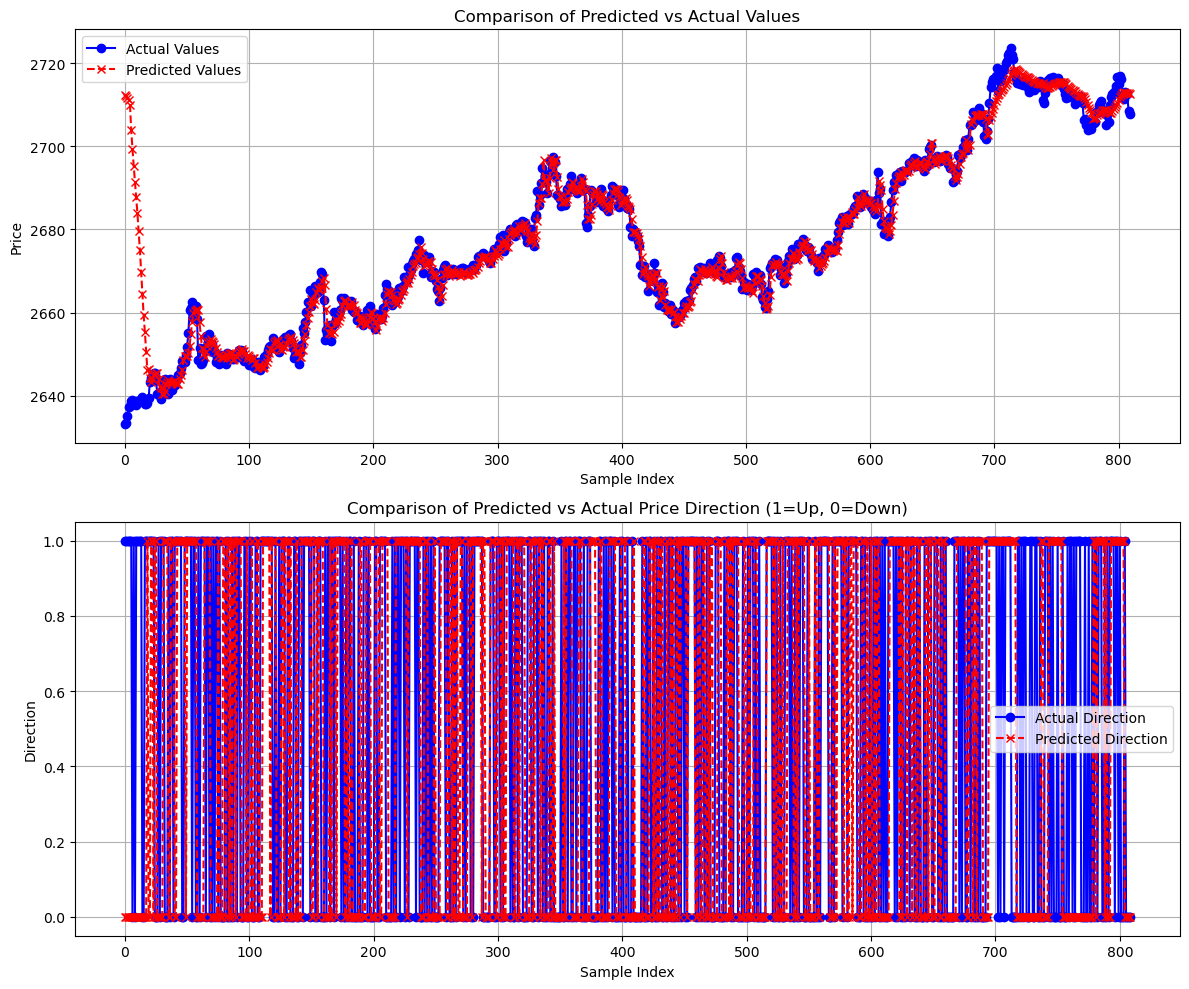

(2.8257072362075677,
 0.0010610164672521668,
 0.9989389835327478,
 0.49938195302843014)

In [35]:
evaluate(results)

In [12]:
def finetune(X_test, scaler, y_test ):
    total_mae = total_mape = total_acc = total_dir_acc = 0
    model = load_model('fine_tune_model_march_22.h5')

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate * 0.1)  # Lower learning rate for fine-tuning
    )
    len_test = len(X_test)
    results = np.zeros((len_test , 1))
    for j in range(len_test):
            current_input = X_test[j].reshape(1, sequence_length)
            prediction = model.predict(current_input, verbose=0)
            results[j] = scaler.inverse_transform(prediction.reshape(-1, 1))
            # results[j] = np.expm1(prediction.reshape(-1, 1))
            # results[j] = prediction*1e5
            # results[j] = scaler.inverse_transform(prediction)
            # Add new sample to buffer
    #             actual = y_test[j].reshape(1, 1)
    # # Add new data to buffer
    #             if len(data_buffer_X) >= sequence_length:87jhhg
            
    #             # # Append new data
    #             # data_buffer_X.append(current_input)
    #             # data_buffer_y.append(actual)
            
    #             # # Update model if we have at least some minimum data uuhnhlhil[pl;.":"jk j hjb, .m ltt.t.t.t8=
    #             # min_samples_to_train = 10  # You can adjust this value;ml/.;'
    #             # if len(data_buffer_X) >= min_samples_to_train:
    #             #     # Convert buffer to NumPy arrays
    #             #     X_train_new = np.vstack(data_buffer_X)
    #             #     y_train_new = np.vstack(data_buffer_y)
                
    #                 # Update the model with buffered data
    #             model = update_model(model, current_input, actual)


            if j < len_test  - 1:
                actual = y_test[j].reshape(1, 1)
                model.fit(current_input,
                            actual,
                            epochs=20,
                            batch_size = 4048,
                            verbose=0)
                
    model.save(f'fine_tune_model_april_15_1st_trial.h5')
    model.save(f'fine_tune_model_april_15_1st_trial.keras')

    print(results.shape)
    print(type(results))
    print(y_test.shape)
    print(type(y_test) )

    mae, mape, acc, dir_acc = evaluate(results)
    
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"Price Accuracy: {acc}")
    print(f"Direction Accuracy: {dir_acc}\n")

    return mae, mape, acc, dir_acc, results.tolist(), model

    # return results, model

    # return (total_mae/n), (total_mape/n), (total_acc/n), (total_dir_acc/n), results.tolist(), model


I0000 00:00:1744660467.357911   84486 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744660467.358385   84486 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744660467.358715   84486 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744660467.490169   84486 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

(955, 1)
<class 'numpy.ndarray'>
(955, 1)
<class 'numpy.ndarray'>


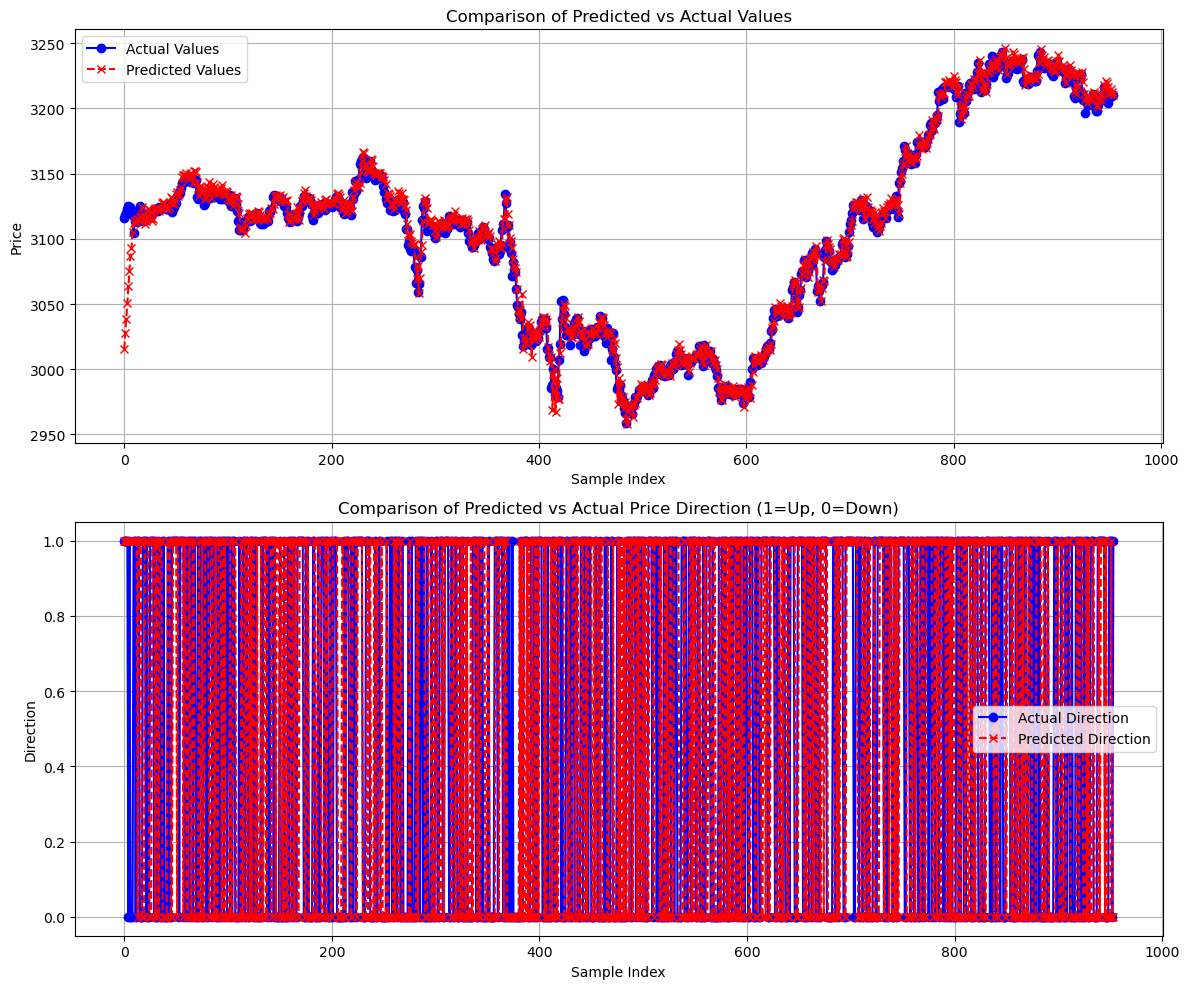

MAE: 5.306601133017007
MAPE: 0.0017091171555266651
Price Accuracy: 0.9982908828444733
Direction Accuracy: 0.4769392033542977



In [13]:
mae , mape, accuracy, dirrection_accuray, predictions, model =finetune(X_test_new, scaler, y_test_new)
# results, model = finetune(X_test_new, scaler, y_test_new)
# finetune(X_test_new, scaler, model, y_test_new)
# mae, mape, acc, dir_acc = evaluate(results)

In [68]:
newData = pd.read_csv("oneCaseTest.csv", delimiter=",")
new_test_data_x = newData['close'].values.reshape(-1, 1)
scaled_new_test_data_x = scaler.transform(new_test_data_x)
# print(scaled_new_test_data_x)
# print(scaler.inverse_transform(scaled_new_test_data_x))
X_test_new_for_one_sample = []

len_test_one_sample = len(scaled_new_test_data_x)
print(scaled_new_test_data_x.shape)
for i in range(len_test_one_sample - sequence_length +1):
    X_test_new_for_one_sample.append(scaled_new_test_data_x[i:i + sequence_length].flatten()) 
print(X_test_new_for_one_sample)
print(X_test_new_for_one_sample[0].shape)
current_input = X_test_new_for_one_sample[0].reshape(1, sequence_length)
print(current_input.shape)
one_sample_prediction = model.predict(current_input, verbose=0)
print(one_sample_prediction)
one_sample_prediction = scaler.inverse_transform(one_sample_prediction)
print(one_sample_prediction)

(60, 1)
[array([1.54971255, 1.54799557, 1.5480903 , 1.54838041, 1.54879486,
       1.54872085, 1.54849882, 1.54711932, 1.54719333, 1.5488067 ,
       1.54945501, 1.54943724, 1.54916786, 1.54954974, 1.55030166,
       1.54980136, 1.55010331, 1.54971847, 1.55001155, 1.54957934,
       1.55070722, 1.55128744, 1.55118975, 1.55132   , 1.55092924,
       1.55071906, 1.55050296, 1.55060065, 1.55063617, 1.55104173,
       1.55136145, 1.5518943 , 1.55038751, 1.55095293, 1.55184694,
       1.55150946, 1.55139993, 1.551246  , 1.55298074, 1.55298074,
       1.55384811, 1.55404645, 1.55449346, 1.55474213, 1.55693572,
       1.55836851, 1.55801919, 1.55672258, 1.5572732 , 1.55756331,
       1.55851357, 1.55878888, 1.55904346, 1.55753962, 1.55491975,
       1.55843956, 1.55757219, 1.55950231, 1.5574893 , 1.55857869])]
(60,)
(1, 60)
[[1.5580257]]
[[3012.821]]


In [ ]:
unseen_data = pd.read_csv("test_on_unseen_data(18_3-11:30).csv", delimiter=",")
unseen_close_data = unseen_data['close'].values.reshape(-1, 1)
scaled_unseen_close_data = scaler.transform(unseen_close_data)


In [77]:
X_test_new_for_unseen_data = []
y_test_new_for_unseen_data = []
len_test_unseen_data = len(scaled_unseen_close_data)
print(scaled_unseen_close_data.shape)
for i in range(len_test_unseen_data - sequence_length ):
    X_test_new_for_unseen_data.append(scaled_unseen_close_data[i:i + sequence_length].flatten())
    y_test_new_for_unseen_data.append(scaled_unseen_close_data[i + sequence_length])
len_test_unseen_data = len(X_test_new_for_unseen_data)
print(len_test_unseen_data)
print(X_test_new_for_unseen_data[0].shape)
print(y_test_new_for_unseen_data[0].shape)
print(len(y_test_new_for_unseen_data))
results = np.zeros((len_test_unseen_data , 1))


(389, 1)
329
(60,)
(1,)
329


In [87]:
original_y_test_unseen_data = scaler.inverse_transform(y_test_new_for_unseen_data)
print(original_y_test_unseen_data)

[[3015.805]
 [3018.34 ]
 [3016.9  ]
 [3018.035]
 [3016.585]
 [3019.74 ]
 [3024.555]
 [3026.76 ]
 [3026.505]
 [3024.64 ]
 [3023.26 ]
 [3021.48 ]
 [3020.305]
 [3025.175]
 [3024.15 ]
 [3023.44 ]
 [3024.075]
 [3022.595]
 [3024.56 ]
 [3027.9  ]
 [3026.91 ]
 [3030.18 ]
 [3028.64 ]
 [3033.705]
 [3034.4  ]
 [3034.63 ]
 [3035.58 ]
 [3027.925]
 [3033.355]
 [3026.045]
 [3029.25 ]
 [3028.745]
 [3028.005]
 [3029.105]
 [3031.565]
 [3031.89 ]
 [3031.79 ]
 [3033.27 ]
 [3035.585]
 [3035.43 ]
 [3036.095]
 [3034.845]
 [3032.835]
 [3032.48 ]
 [3032.67 ]
 [3033.445]
 [3033.47 ]
 [3035.49 ]
 [3035.94 ]
 [3036.7  ]
 [3037.23 ]
 [3037.24 ]
 [3035.665]
 [3034.935]
 [3034.7  ]
 [3033.96 ]
 [3034.48 ]
 [3032.725]
 [3033.84 ]
 [3033.4  ]
 [3034.56 ]
 [3033.775]
 [3032.63 ]
 [3033.74 ]
 [3031.955]
 [3031.17 ]
 [3033.565]
 [3033.055]
 [3031.49 ]
 [3029.215]
 [3029.82 ]
 [3028.015]
 [3029.52 ]
 [3031.415]
 [3029.84 ]
 [3032.78 ]
 [3033.465]
 [3034.935]
 [3034.595]
 [3035.55 ]
 [3036.415]
 [3035.285]
 [3037.05 ]
 [30

In [83]:
current_input = X_test_new_for_unseen_data[0].reshape(1, sequence_length)
current_input = scaler.inverse_transform(current_input)
print(current_input.shape)
print(current_input)
print(current_input[0][-1])
real_previous_input = (current_input[0][-1])
# print(scaler.inverse_transform(real_previous_input))


(1, 60)
[[2998.78  2995.88  2996.04  2996.53  2997.23  2997.105 2996.73  2994.4
  2994.525 2997.25  2998.345 2998.315 2997.86  2998.505 2999.775 2998.93
  2999.44  2998.79  2999.285 2998.555 3000.46  3001.44  3001.275 3001.495
  3000.835 3000.48  3000.115 3000.28  3000.34  3001.025 3001.565 3002.465
  2999.92  3000.875 3002.385 3001.815 3001.63  3001.37  3004.3   3004.3
  3005.765 3006.1   3006.855 3007.275 3010.98  3013.4   3012.81  3010.62
  3011.55  3012.04  3013.645 3014.11  3014.54  3012.    3007.575 3013.52
  3012.055 3015.315 3011.915 3013.755]]
3013.755


In [84]:
direction = []
for j in range(len_test_unseen_data):
        current_input = X_test_new_for_unseen_data[j].reshape(1, sequence_length)
        og_current_input = scaler.inverse_transform(current_input)
        prediction = model.predict(current_input, verbose=0)
        results[j] = scaler.inverse_transform(prediction.reshape(-1, 1))
        real_previous_input = (current_input[0][-1])
        
        if results[j] > real_previous_input:
                direction.append(1)  # Price went up
        else:
                direction.append(0)
        if j < len_test  - 1:
                actual = y_test_new_for_unseen_data[j].reshape(1, 1)
                model.fit(current_input,
                            actual,
                            epochs=20,
                            batch_size = 4048,
                            verbose=0)

print(results.shape)
print(results)
print(direction)

(329, 1)
[[3012.82104492]
 [3012.20581055]
 [3019.14501953]
 [3018.546875  ]
 [3019.01391602]
 [3015.66650391]
 [3017.95947266]
 [3024.76513672]
 [3029.48071289]
 [3031.08056641]
 [3024.45092773]
 [3020.60449219]
 [3021.89160156]
 [3020.72192383]
 [3026.25390625]
 [3023.45776367]
 [3022.73217773]
 [3021.54516602]
 [3021.51831055]
 [3026.46972656]
 [3026.35693359]
 [3027.94360352]
 [3030.96069336]
 [3029.66381836]
 [3030.76269531]
 [3032.7668457 ]
 [3034.14501953]
 [3035.92138672]
 [3030.0390625 ]
 [3036.85009766]
 [3025.86547852]
 [3024.38574219]
 [3028.67700195]
 [3028.62817383]
 [3025.92993164]
 [3033.73730469]
 [3036.17016602]
 [3032.88745117]
 [3029.91455078]
 [3038.01611328]
 [3038.08813477]
 [3035.73022461]
 [3032.40966797]
 [3030.56713867]
 [3030.85986328]
 [3035.0456543 ]
 [3033.57470703]
 [3033.48364258]
 [3035.47583008]
 [3032.90942383]
 [3034.44458008]
 [3037.66577148]
 [3038.76977539]
 [3036.35839844]
 [3036.5234375 ]
 [3033.49023438]
 [3032.14990234]
 [3032.94433594]
 [303

In [86]:
def calculate_direction_accuracy(actual_values, predicted_values):
    """
    Calculate accuracy of predicted price movement direction
    Returns: accuracy and arrays of actual and predicted directions
    """
    # Calculate actual price movements (1 for up, 0 for down)
    actual_direction = (actual_values[1:] > actual_values[:-1]).astype(int)

    # Calculate predicted price movements (1 for up, 0 for down)
    predicted_direction = (predicted_values[1:] > predicted_values[:-1]).astype(int)

    # Calculate accuracy
    direction_accuracy = np.mean(actual_direction == predicted_direction)

    return direction_accuracy, actual_direction, predicted_direction


In [103]:
def evalu(predictions, y_test_original):
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)

    # Calculate direction accuracy
    dir_acc, actual_dir, pred_dir = calculate_direction_accuracy(y_test_original, predictions)
    print("printing the pred_dir")
    print(type(pred_dir))
    print(pred_dir)
    
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"Price Accuracy: {1 - mape}")
    print(f"Direction Accuracy: {dir_acc}\n")

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Price predictions
    ax1.plot(y_test_original, label="Actual Values", color="blue", marker='o')
    ax1.plot(predictions, label="Predicted Values", color="red",
            linestyle='dashed', marker='x')
    ax1.set_title("Comparison of Predicted vs Actual Values")
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Direction predictions
    ax2.plot(actual_dir, label="Actual Direction", color="blue", marker='o')
    ax2.plot(pred_dir, label="Predicted Direction", color="red",
            linestyle='dashed', marker='x')
    ax2.set_title("Comparison of Predicted vs Actual Price Direction (1=Up, 0=Down)")
    ax2.set_xlabel("Sample Index")
    ax2.set_ylabel("Direction")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    
    return pred_dir  # Modified return statement


printing the pred_dir
<class 'numpy.ndarray'>
[0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0
 0 1 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1
 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1
 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0
 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1
 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0
 0 1 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 1
 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1]
MAE: 2.366292772843851
MAPE: 0.0007799068327994798
Price Accuracy: 0.9992200931672005
Direction Accuracy: 0.49977691850089234



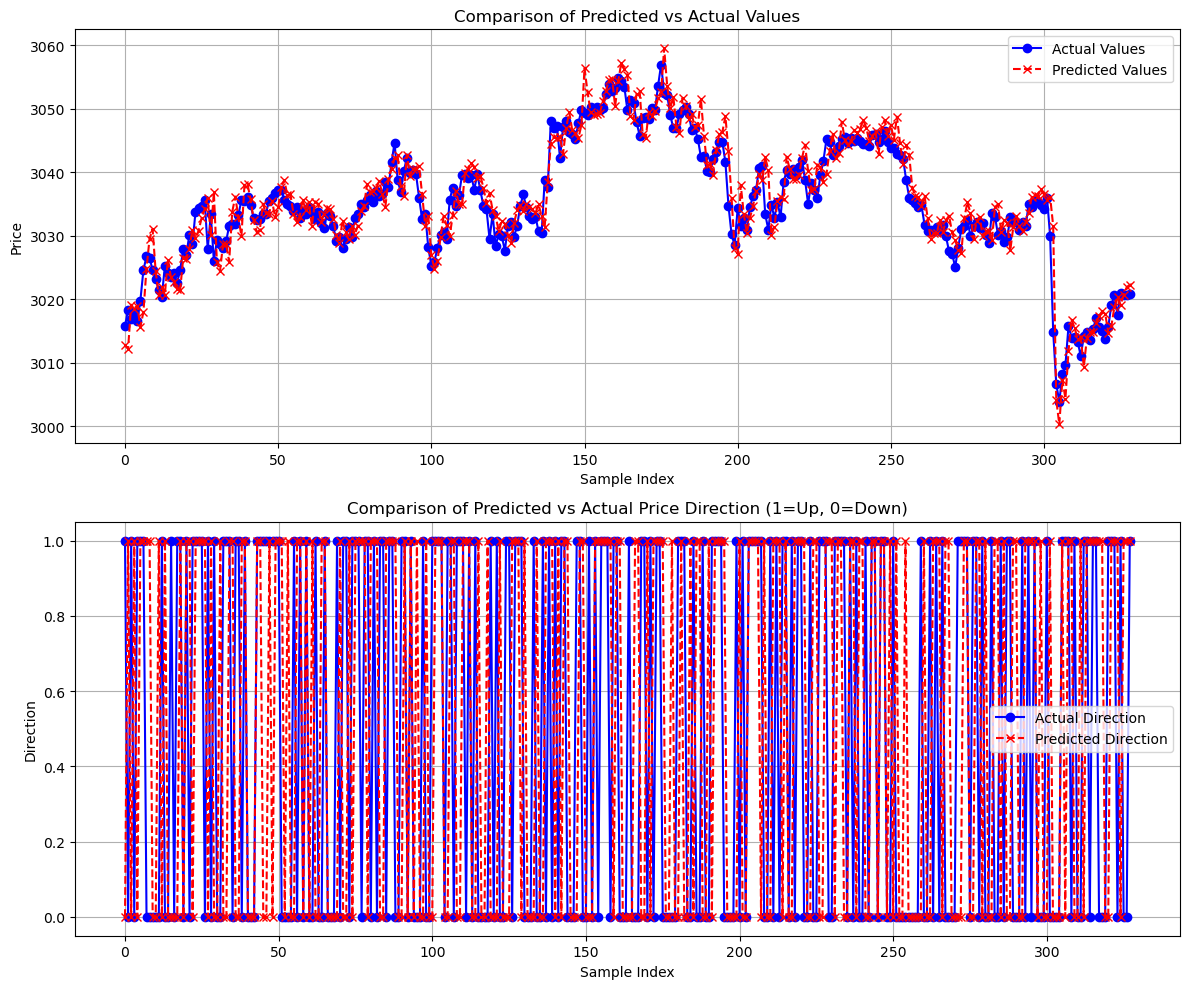

In [121]:
pred_dir = evalu(results, original_y_test_unseen_data)


In [105]:
print(pred_dir)


[[0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]


In [106]:
print(type(pred_dir))
print(type(results))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [126]:
data = pd.read_csv('test_on_unseen_data(18_3-11:30).csv')  # Replace with your actual file name
time_series = data['datetime'].iloc[60:]  # Get time from line 62 onwards
print(time_series)

pred_dir = np.array(pred_dir)
# pred_dir = np.concatenate(([1], pred_dir))
# print(pred_dir)
pred_dir = np.array(pred_dir).flatten()
results = results.flatten()
time_series = time_series.reset_index(drop=True)  # Reset index for time series

# Print original shapes
print("Original shapes:")
print("Time series:", time_series.shape)
print("Pred_dir:", pred_dir.shape)
print("Results:", results.shape)
print(time_series[0])
print(results[0])
print(pred_dir[0])
print(original_y_test_unseen_data[0])

# Create a DataFrame with the results
df_results = pd.DataFrame({
    'Time': time_series,
    'Price': results.flatten(),  # Flatten in case results is 2D
    'Direction': pred_dir
})

# Save to CSV
df_results.to_csv('predictions_with_direction.csv', index=False)

60     2025-03-18 12:45:00
61     2025-03-18 13:00:00
62     2025-03-18 13:15:00
63     2025-03-18 13:30:00
64     2025-03-18 13:45:00
              ...         
384    2025-03-22 00:45:00
385    2025-03-22 01:00:00
386    2025-03-22 01:15:00
387    2025-03-22 01:30:00
388    2025-03-22 01:45:00
Name: datetime, Length: 329, dtype: object
Original shapes:
Time series: (329,)
Pred_dir: (329,)
Results: (329,)
2025-03-18 12:45:00
3012.821044921875
1
[3015.805]


In [128]:
data = pd.read_csv('data_1m.csv')  # Replace with your actual file name
data = data[['datetime', 'close']]
print(data)

# Save to CSV
# df_results.to_csv('predictions_with_direction.csv', index=False)

                 datetime     close
0     2025-03-18 11:30:00  3008.020
1     2025-03-18 11:31:00  3008.945
2     2025-03-18 11:32:00  3009.995
3     2025-03-18 11:33:00  3010.980
4     2025-03-18 11:34:00  3012.065
...                   ...       ...
4992  2025-03-22 01:42:00  3020.110
4993  2025-03-22 01:43:00  3020.525
4994  2025-03-22 01:44:00  3020.600
4995  2025-03-22 01:45:00  3020.790
4996  2025-03-22 01:46:00  3020.775

[4997 rows x 2 columns]
